In [22]:
import tensorflow as tf
print(tf.__version__)
import cv2
print(cv2.__version__)

2.19.0
4.12.0


In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [24]:
# ==========================================
# 1. Importar librerías y dataset MNIST
# ==========================================
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Cargar dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalizar a [0,1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


In [25]:
# ==========================================
# EXTRA: Normalización y centrado automático
# ==========================================
def center_image(img):
    # Umbralización ligera
    _, th = cv2.threshold((img * 255).astype(np.uint8), 30, 255, cv2.THRESH_BINARY)

    # Encontrar contornos
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img

    # Bounding box del dígito
    x, y, w, h = cv2.boundingRect(contours[0])

    # Recorte del dígito
    crop = img[y:y+h, x:x+w]

    # Redimensionar manteniendo proporción
    crop = cv2.resize(crop, (20,20))

    # Colocar en un canvas 28x28 centrado
    canvas = np.zeros((28,28), dtype=np.float32)
    start_x = (28 - 20) // 2
    start_y = (28 - 20) // 2
    canvas[start_y:start_y+20, start_x:start_x+20] = crop

    return canvas

# Aplicar a train y test
train_images = np.array([center_image(img) for img in train_images])
test_images  = np.array([center_image(img) for img in test_images])


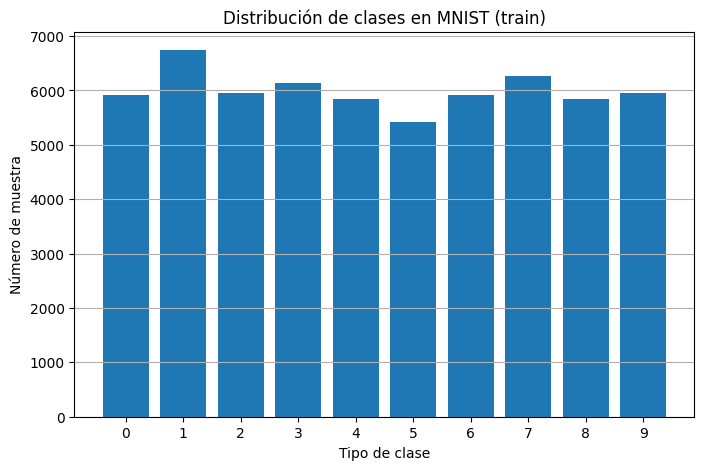

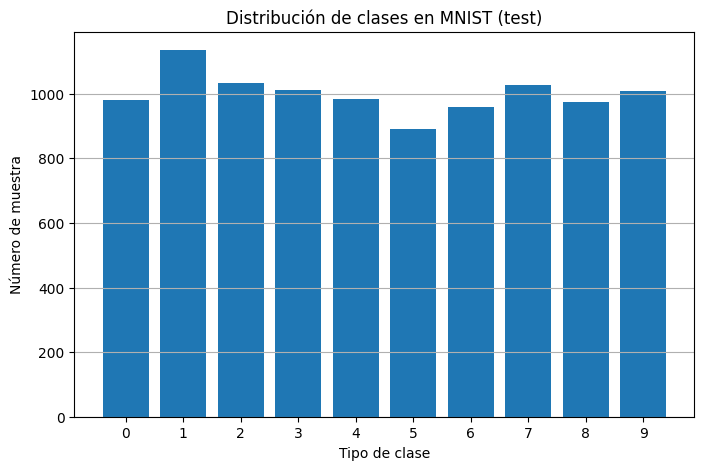

In [26]:
# ==========================================
# 2. Distribución de clases
# ==========================================
unique_classes, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_classes, counts, tick_label=unique_classes)
plt.title("Distribución de clases en MNIST (train)")
plt.xlabel("Tipo de clase")
plt.ylabel("Número de muestra")
plt.grid(axis='y')
plt.show()

unique_classes, counts = np.unique(test_labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_classes, counts, tick_label=unique_classes)
plt.title("Distribución de clases en MNIST (test)")
plt.xlabel("Tipo de clase")
plt.ylabel("Número de muestra")
plt.grid(axis='y')
plt.show()

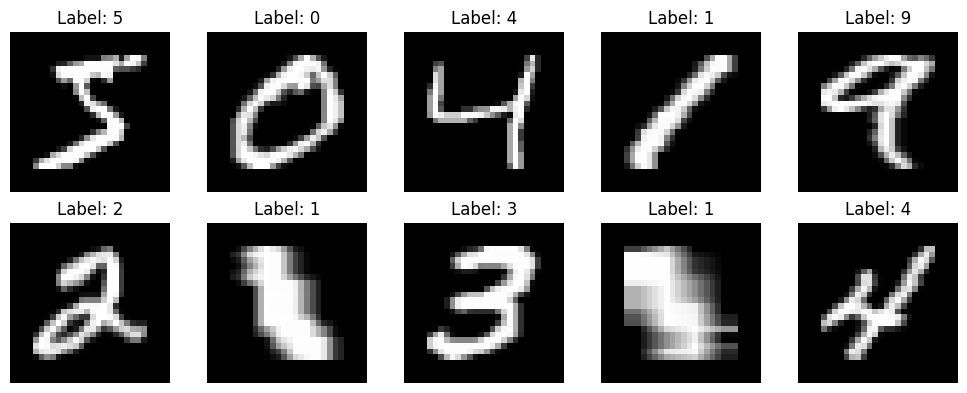

Training pixel range: min=0.0, max=1.0
Testing pixel range: min=0.0, max=1.0


In [27]:
# ==========================================
# 3. Mostrar ejemplos del dataset
# ==========================================
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Training pixel range: min={train_images.min()}, max={train_images.max()}")
print(f"Testing pixel range: min={test_images.min()}, max={test_images.max()}")

In [29]:
# ==========================================
# 4. Crear y compilar el modelo
# ==========================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    Reshape((28, 28, 1), input_shape=(28, 28)),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==========================================
# EXTRA: Data Augmentation
# ==========================================
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15
)

datagen.fit(train_images.reshape(-1, 28, 28, 1))

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# ==========================================
# 5. Train/Validation Split y entrenamiento
# ==========================================
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# ---- 1) Separar train y validation ----
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# ---- 2) Early stopping ----
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

# ---- 3) Entrenar usando data augmentation SOLO en train ----
history = model.fit(
    datagen.flow(X_train.reshape(-1, 28, 28, 1), y_train, batch_size=64),
    validation_data=(X_val.reshape(-1, 28, 28, 1), y_val),
    epochs=50,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.6756 - loss: 1.0035 - val_accuracy: 0.9364 - val_loss: 0.2100
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9064 - loss: 0.3076 - val_accuracy: 0.9579 - val_loss: 0.1366
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9342 - loss: 0.2214 - val_accuracy: 0.9582 - val_loss: 0.1342
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9405 - loss: 0.1901 - val_accuracy: 0.9617 - val_loss: 0.1237
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9440 - loss: 0.1784 - val_accuracy: 0.9603 - val_loss: 0.1249
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9487 - loss: 0.1603 - val_accuracy: 0.9653 - val_loss: 0.1069
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9519 - loss: 0.1533 - val_accuracy: 0.9624 - val_loss: 0.1208
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9527 - loss: 0.1470 - 

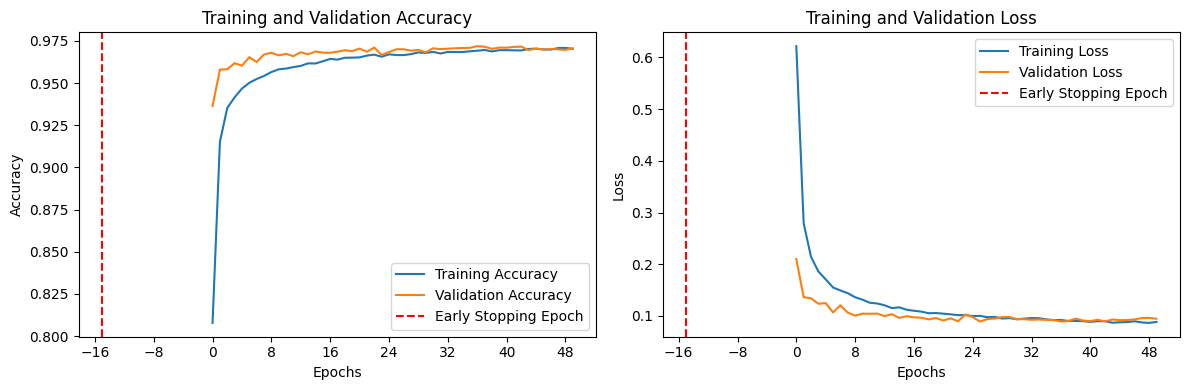

In [32]:
# ==========================================
# 6. Graficar resultados del entrenamiento
# ==========================================
from matplotlib.ticker import MaxNLocator

stopped_epoch = early_stop.stopped_epoch
best_epoch = stopped_epoch - early_stop.patience

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer values on x-axis
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer values on x-axis
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
# ==========================================
# 7. Capturar imagen con la cámara (Colab)
# ==========================================
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

filename = take_photo()
print("Imagen capturada:", filename)

<IPython.core.display.Javascript object>

Imagen capturada: photo.jpg


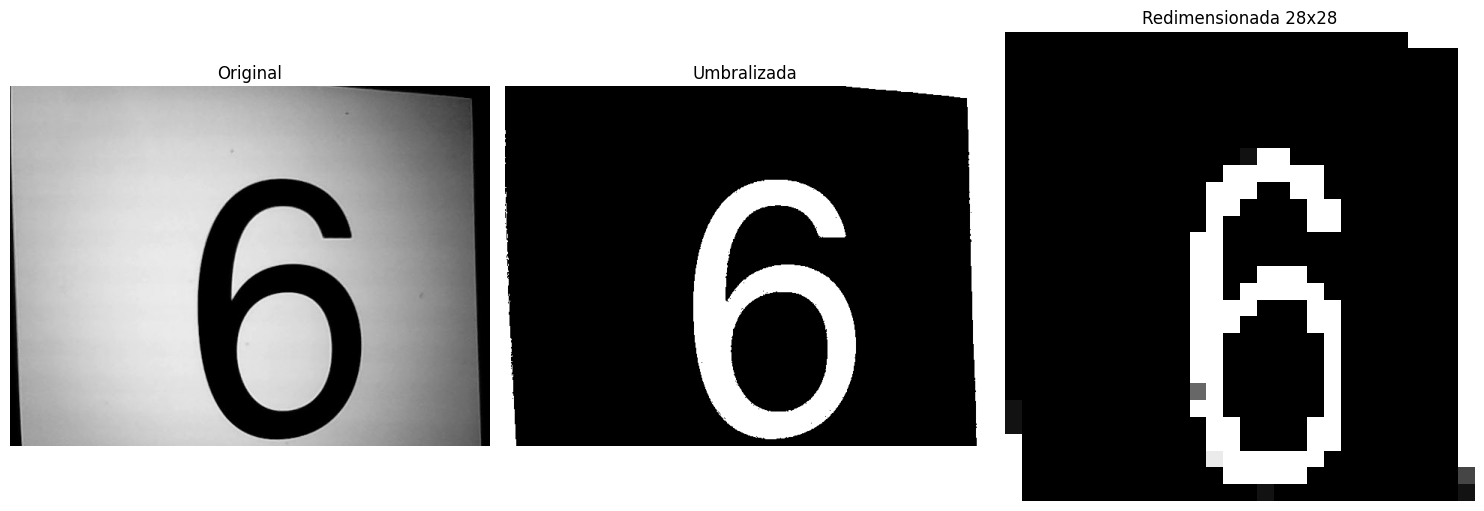

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step

Digit | Probability
-------------------
  0   |   0.00236
  1   |   0.00000
  2   |   0.11639
  3   |   0.01446
  4   |   0.00000
  5   |   0.10509
  6   |   0.02270
  7   |   0.00000
  8   |   0.73899
  9   |   0.00002

 Predicted digit: 8


In [34]:
# ==========================================
# 8. Procesar imagen y predecir dígito
# ==========================================
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY_INV)
resized = cv2.resize(thresh, (28, 28))

# Mostrar las tres etapas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(thresh, cmap='gray')
axes[1].set_title('Umbralizada')
axes[1].axis('off')
axes[2].imshow(resized, cmap='gray')
axes[2].set_title('Redimensionada 28x28')
axes[2].axis('off')
plt.tight_layout()
plt.show()

# Preparar imagen para predicción
input_image = resized.astype('float32') / 255
input_image = input_image.reshape(1, 28, 28)

# Predicción
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)

print("\nDigit | Probability")
print("-------------------")
for i, prob in enumerate(prediction[0]):
    print(f"  {i}   |   {prob:.5f}")
print(f"\n Predicted digit: {predicted_label}")


In [35]:
# Save the model
model.save("my_model.h5")

🔼 Sube tu archivo imagenes.zip con tus 50 imágenes


Saving imagenes.zip to imagenes (2).zip
✔️ Imágenes extraídas en la carpeta 'imagenes'

📁 Contenido de la carpeta 'imagenes':
['test_digits-']

📸 Total de imágenes encontradas: 50


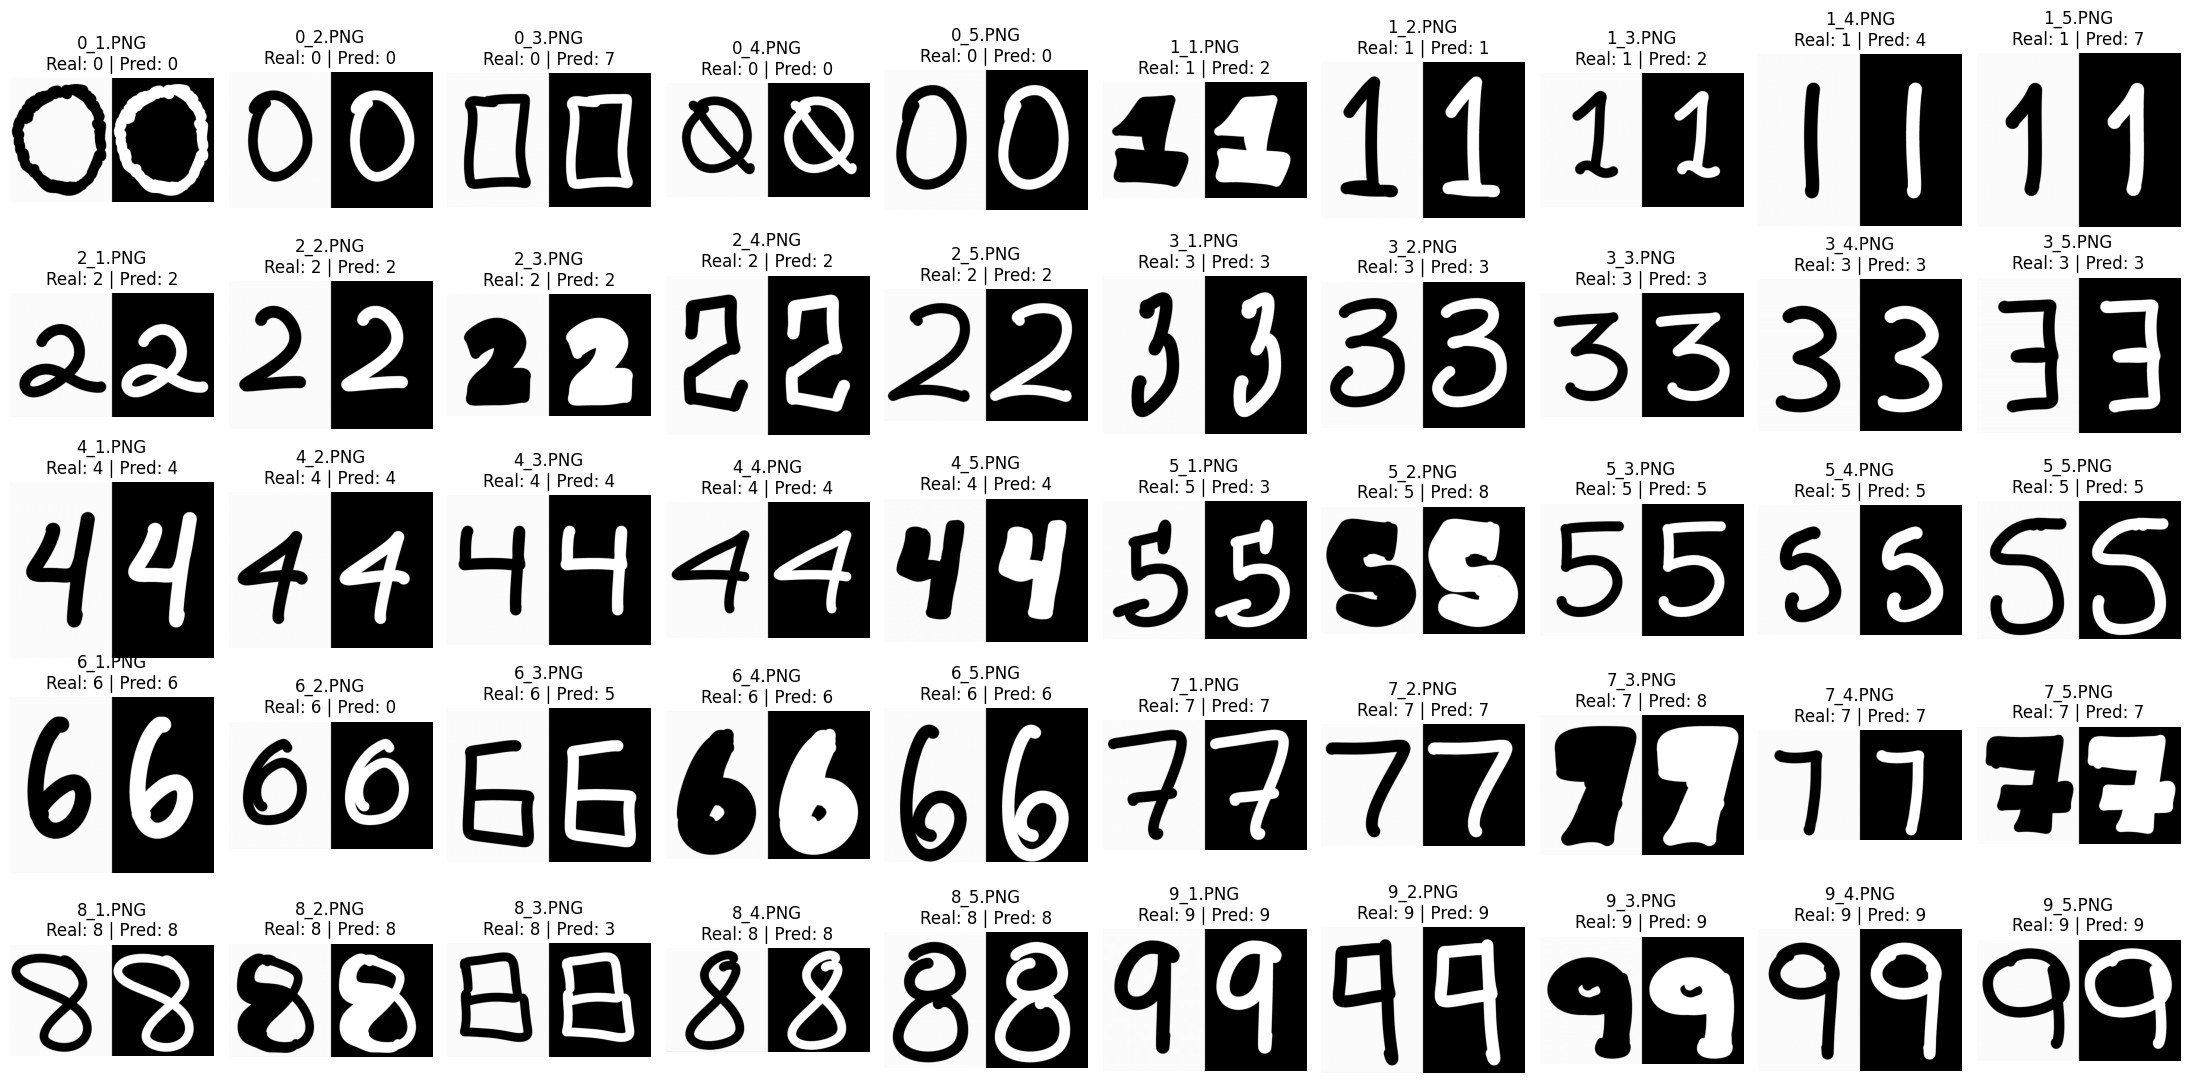


📊 Precisión en las 50 imágenes: 78.00%


In [36]:
# ==========================================
# 9. Evaluar el modelo con 50 imágenes personalizadas
# ==========================================
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile

# --- SUBIR ZIP ---
print("🔼 Sube tu archivo imagenes.zip con tus 50 imágenes")
uploaded = files.upload()

zip_name = list(uploaded.keys())[0]  # nombre del zip subido

# Crear carpeta para extraer
os.makedirs("imagenes", exist_ok=True)

# Extraer ZIP
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("imagenes")

print("✔️ Imágenes extraídas en la carpeta 'imagenes'")

# Mostrar contenido para depuración
print("\n📁 Contenido de la carpeta 'imagenes':")
print(os.listdir("imagenes"))

# --- BUSCAR TODAS LAS IMÁGENES (sin importar subcarpetas) ---
imagenes = []
for root, dirs, files in os.walk("imagenes"):
    for f in files:
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            imagenes.append(os.path.join(root, f))

imagenes = sorted(imagenes)

print(f"\n📸 Total de imágenes encontradas: {len(imagenes)}")


# --- EVALUACIÓN ---
correctas = 0
total = 0
resultados = []

for ruta in imagenes:

    # Leer imagen
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"⚠️ No se pudo leer: {ruta}")
        continue

    # Preprocesamiento (igual al del modelo)
    _, thresh = cv2.threshold(img, 105, 255, cv2.THRESH_BINARY_INV)
    resized = cv2.resize(thresh, (28, 28))

    # Preparar para predicción
    input_img = resized.astype('float32') / 255.0
    input_img = input_img.reshape(1, 28, 28)

    # Predicción
    probs = model.predict(input_img, verbose=0)
    pred = np.argmax(probs)

    # Obtener etiqueta real desde el nombre
    nombre = os.path.basename(ruta)

    try:
        real = int(nombre[0])
    except:
        print(f"⚠️ Nombre inesperado: {nombre}")
        continue

    if pred == real:
        correctas += 1
    total += 1

    resultados.append((img, thresh, pred, real, nombre))


# --- MOSTRAR RESULTADOS ---
fig, axes = plt.subplots(5, 10, figsize=(22, 11))
axes = axes.flatten()

# Evitar error si hay menos de 50
to_show = min(50, len(resultados))

for i in range(to_show):
    orig, th, pred, real, nombre = resultados[i]
    combined = np.hstack((orig, th))
    axes[i].imshow(combined, cmap='gray')
    axes[i].set_title(f"{nombre}\nReal: {real} | Pred: {pred}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# --- PRECISIÓN ---
if total > 0:
    precision = (correctas / total) * 100
    print(f"\n📊 Precisión en las {total} imágenes: {precision:.2f}%")
else:
    print("\n⚠️ No se pudieron evaluar imágenes.")


In [37]:
%%writefile real_time_prediction.py
import cv2
import numpy as np
import tensorflow as tf

# Cargar el modelo entrenado
model = tf.keras.models.load_model("my_model.h5")

cap = cv2.VideoCapture(0)

print("Presiona 'q' para salir, 's' para pausar/reanudar.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, th = cv2.threshold(gray, 105, 255, cv2.THRESH_BINARY_INV)
        resized = cv2.resize(th, (28, 28))

        input_img = resized.astype("float32") / 255.0
        input_img = input_img.reshape(1, 28, 28)

        prediction = model.predict(input_img, verbose=0)
        predicted_label = np.argmax(prediction)

        cv2.putText(frame, f"Prediccion: {predicted_label}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        cv2.imshow("Real-time prediction", frame)

        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break

        elif key == ord('s'):
            print("⏸️  Pausa (presiona 's' para resumir)")
            cv2.imshow("Procesada (28x28)", cv2.resize(resized, (280, 280), interpolation=cv2.INTER_NEAREST))
            while True:
                key2 = cv2.waitKey(1) & 0xFF
                if key2 == ord('s'):
                    cv2.destroyWindow("Procesada (28x28)")
                    print("▶️  Reanudado")
                    break

except KeyboardInterrupt:
    pass

finally:
    cap.release()
    cv2.destroyAllWindows()


Writing real_time_prediction.py
